In [2]:
from transformers import AutoTokenizer, BertForQuestionAnswering, BertModel, AutoModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import rouge_score


/Users/tanmaygoyal/opt/anaconda3/envs/pytorch_acc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Getting Sentence embeddings from "all-mpnet-base-v2" and calculating cosine similarity

In [3]:
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
question = "he is a good man"
text = "he is a good man"
sentences = ["he is a good man", "he is a great man"]

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print('Sentence Embeddings:', sentence_embeddings)
print('Cosine Similarity from embeddings generated by the model: {:4f}'.format(torch.cosine_similarity(sentence_embeddings[0].unsqueeze(0), sentence_embeddings[1].unsqueeze(0)).item()))

Sentence Embeddings: tensor([[ 0.0314,  0.0596,  0.0288,  ...,  0.0033,  0.0556,  0.0068],
        [ 0.0211,  0.0423,  0.0354,  ...,  0.0096,  0.0508, -0.0001]])
Cosine Similarity from embeddings generated by the model: 0.884947


### Calculating our similarity scores

In [4]:
def get_ticks_attention_scores(sentence1 , sentence2):
    model_version = 'sentence-transformers/all-mpnet-base-v2'
    model = AutoModel.from_pretrained(model_version, output_attentions=True, output_hidden_states=True)
    tokenizer = AutoTokenizer.from_pretrained(model_version)

    # generating the embeddings
    inputs = tokenizer(sentence1 , sentence2 , return_tensors='pt')
    input_ids = inputs['input_ids']
    attention = model(input_ids)[-1]
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

    # generating the ticks
    ticks = []
    for j in range(len(inputs.input_ids)):
        for i in range(len(inputs.input_ids[j])):
            ticks.append(tokenizer.decode(inputs.input_ids[0][i]))

    # generating the attention matrix
    attention_tensors = []
    for tensor in model(input_ids).attentions:
        attention_tensors.append(tensor.detach().numpy())
    attentions_temp = torch.tensor(np.array(attention_tensors))
    
    return attentions_temp , ticks

In [5]:
def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)
 
 
def get_hidden_states(encoded, token_ids_word, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
        Select only those subword token outputs that belong to our word of interest
        and average them."""
    with torch.no_grad():
        output = model(**encoded)
 
    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]
 
    return word_tokens_output.mean(dim=0)
 
 
def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
        that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
 
    return get_hidden_states(encoded, token_ids_word, model, layers)
 
 
def get_BERT_embeddings(layers , sent1 , sent2):
    # Use last four layers by default
    layers = [-4, -3, -2, -1] if layers is None else layers
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    model = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

    sent1_embeddings = []
    sent2_embeddings = []
    for w in sent1.split(" "):
        sent1_embeddings.append(get_word_vector(sent1, get_word_idx(sent1, w), tokenizer, model, layers))
    for w in sent2.split(" "):
        sent2_embeddings.append(get_word_vector(sent2 , get_word_idx(sent2, w), tokenizer, model, layers))
    # print(type(sent1_embeddings), type(sent2_embeddings), type(sent1_embeddings[0]))
    return sent1_embeddings, sent2_embeddings 

def get_Word2Vec_embeddings(sent1 , sent2):
    from gensim.models import Word2Vec
    from gensim.models import KeyedVectors
    import gensim.downloader as api
    word_vectors = api.load("word2vec-google-news-300")
    sent1_embeddings = []
    sent2_embeddings = []
    for w in sent1.split(" "):
        sent1_embeddings.append(torch.tensor(word_vectors[w]))
    for w in sent2.split(" "):
        sent2_embeddings.append(torch.tensor(word_vectors[w]))
    return sent1_embeddings, sent2_embeddings


def get_glove_embeddings(sent1 , sent2):
    from gensim.models import Word2Vec
    from gensim.models import KeyedVectors
    import gensim.downloader as api
    word_vectors = api.load("glove-wiki-gigaword-100")
    sent1_embeddings = []
    sent2_embeddings = []
    for w in sent1.split(" "):
        sent1_embeddings.append(torch.tensor(word_vectors[w]))
    for w in sent2.split(" "):
        sent2_embeddings.append(torch.tensor(word_vectors[w]))
    return sent1_embeddings, sent2_embeddings


In [6]:
def get_scores(attention_matrix , s1_embeddings , s2_embeddings):
    sum = 0
    len_s1 = attention_matrix.shape[0]-2 # to account for the [SEP]
    len_s2 = attention_matrix.shape[1]-2 # to account foe the [SEP]

    if len(s1_embeddings) != len_s1 or len(s2_embeddings) != len_s2:
        print("Incorrect dimensions of embeddings or attention matrix")
        print("s1_embeddings: ", len(s1_embeddings))
        print("s2_embeddings: ", len(s2_embeddings))
        print("attention_matrix: ", attention_matrix.shape)
        return
    
    for i in range(len_s1):
        correct_idx = i+1 # since we have [SEP] at 0 index
        attention = attention_matrix[correct_idx]
        sorted_indices = np.argsort(attention)
        if sorted_indices[-1] not in [0 , len(attention)-1]:
            most_attention = sorted_indices[-1]
        elif sorted_indices[-2] not in [0 , len(attention)-1]:
            most_attention = sorted_indices[-2]
        else:
            most_attention = sorted_indices[-3]
        most_attention_correct_idx = most_attention - 1  # since 0 index is SEP
        sum += torch.cosine_similarity(s1_embeddings[i].unsqueeze(0) , s2_embeddings[most_attention_correct_idx].unsqueeze(0)).item()

    full_score =sum / len_s1

    return full_score


In [9]:
def similarity_score(sentence1 , sentence2 , plot_attention = True, embeddings='glove'):
    '''
    Function to calculate the similarity score between two sentences
    Parameters:
    sentence1 : sentence 1
    sentence2 : sentence 2
    plot_attention : Whether to plot the attention matrix or not    
    '''

    
    sentence1 = sentence1.lower()
    sentence2 = sentence2.lower()


    attention_matrix , ticks = get_ticks_attention_scores(sentence1 , sentence2)
    if embeddings == 'bert':
        embeddings_s1 , embeddings_s2 = get_BERT_embeddings(None , sentence1 , sentence2)
    if embeddings == 'word2vec':
        embeddings_s1 , embeddings_s2 = get_Word2Vec_embeddings(sentence1 , sentence2)
    if embeddings == 'glove':
        embeddings_s1 , embeddings_s2 = get_glove_embeddings(sentence1 , sentence2)
    # embeddings_s1 , embeddings_s2 = get_Word2Vec_embeddings(sentence1 , sentence2)
    
    sep_indices = [i for i in range(len(ticks)) if ticks[i] in ["<s>" , "</s>"]]
    if len(sep_indices) != 4:
        print("Incorrect number of [SEP] tokens")
        return
    
    sentence_divider = sep_indices[1]

    relevant_attention_matrix = []
    # for A->B
    relevant_attention_matrix.append(attention_matrix.mean(axis=2)[-1][0][:sentence_divider+1,sentence_divider+1:])
    # for B->A
    relevant_attention_matrix.append(attention_matrix.mean(axis=2)[-1][0][sentence_divider+1:,:sentence_divider+1])
    
    if plot_attention:
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.title("Attention from Reference -> Generated")
        sns.heatmap(relevant_attention_matrix[0],xticklabels = ticks[sentence_divider+1:] , yticklabels = ticks[:sentence_divider+1], annot=True)
        plt.subplot(1,2,2)
        plt.title("Attention Matrix from Generated -> Reference")
        sns.heatmap(relevant_attention_matrix[1],xticklabels = ticks[:sentence_divider+1] , yticklabels = ticks[sentence_divider+1:], annot=True)
        plt.show()

    # getting the scores
    return max(get_scores(relevant_attention_matrix[0] , embeddings_s1 , embeddings_s2) , get_scores(relevant_attention_matrix[1] , embeddings_s2 , embeddings_s1))

In [48]:

reference = "he is the good man"
predict1 = "he is the best man"
predict2 = "he is the best man of the groom"

print("Similarity Score with Glove: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='glove'))
print("Similarity Score with BERT: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='bert'))
rogue = evaluate.load('rouge')
print("Rouge Score: ", rogue.compute(predictions=[predict1] , references=[reference]))

print("Similarity Score with Glove: ", similarity_score(reference , predict2 , plot_attention=False , embeddings='glove'))
print("Similarity Score with BERT: ", similarity_score(reference , predict2 , plot_attention=False , embeddings='bert'))
# rouge = evaluate.load('rouge')
print("Rouge Score: ", rogue.compute(predictions=[predict2] , references=[reference]))


Similarity Score with Glove:  0.822573447227478
Similarity Score with BERT:  0.7127435266971588
Rouge Score:  {'rouge1': 0.8000000000000002, 'rouge2': 0.5, 'rougeL': 0.8000000000000002, 'rougeLsum': 0.8000000000000002}
Similarity Score with Glove:  0.6111858822405338
Similarity Score with BERT:  0.4353034757077694
Rouge Score:  {'rouge1': 0.6153846153846154, 'rouge2': 0.36363636363636365, 'rougeL': 0.6153846153846154, 'rougeLsum': 0.6153846153846154}


In [11]:

reference = "he is taking a flight to mumbai"
predict1 = "he is arriving in mumbai by airplane"
predict2 = "he is coming from mumbai by airplane"
predict3 = "he is travelling via air to mumbai"

print("Similarity Score with Glove for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='glove'))
print("Similarity Score with Glove for sentence 2:", similarity_score(reference , predict2 , plot_attention=False , embeddings='glove'))
print("Similarity Score with Glove for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='glove'))
print("Similarity Score with BERT for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='bert'))
print("Similarity Score with BERT for sentence 2: ", similarity_score(reference , predict2 , plot_attention=False , embeddings='bert'))
print("Similarity Score with BERT for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='bert'))
rogue = evaluate.load('rouge')
print("Rouge Score for sentence 1: ", rogue.compute(predictions=[predict1] , references=[reference]))
print("Rouge Score for sentence 2: ", rogue.compute(predictions=[predict2] , references=[reference]))
print("Rouge Score for sentence 3: ", rogue.compute(predictions=[predict3] , references=[reference]))


Similarity Score with Glove for sentence 1:  0.5079703543867383
Similarity Score with Glove for sentence 2: 0.43864552889551434
Similarity Score with Glove for sentence 3:  0.47408916694777353
Similarity Score with BERT for sentence 1:  0.5915153878075736
Similarity Score with BERT for sentence 2:  0.5364494749477932
Similarity Score with BERT for sentence 3:  0.5168611109256744
Rouge Score for sentence 1:  {'rouge1': 0.42857142857142855, 'rouge2': 0.16666666666666666, 'rougeL': 0.42857142857142855, 'rougeLsum': 0.42857142857142855}
Rouge Score for sentence 2:  {'rouge1': 0.42857142857142855, 'rouge2': 0.16666666666666666, 'rougeL': 0.42857142857142855, 'rougeLsum': 0.42857142857142855}
Rouge Score for sentence 3:  {'rouge1': 0.5714285714285714, 'rouge2': 0.3333333333333333, 'rougeL': 0.5714285714285714, 'rougeLsum': 0.5714285714285714}


In [55]:

reference = "he is taking a flight to mumbai"
predict1 = "he is taking a plane to go to mumbai"

print("Similarity Score with Glove for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='glove'))
# print("Similarity Score with Glove for sentence 2:", similarity_score(reference , predict2 , plot_attention=False , embeddings='glove'))
# print("Similarity Score with Glove for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='glove'))
print("Similarity Score with BERT for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='bert'))
# print("Similarity Score with BERT for sentence 2: ", similarity_score(reference , predict2 , plot_attention=False , embeddings='bert'))
# print("Similarity Score with BERT for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='bert'))
rogue = evaluate.load('rouge')
print("Rouge Score for sentence 1: ", rogue.compute(predictions=[predict1] , references=[reference]))
# print("Rouge Score for sentence 2: ", rogue.compute(predictions=[predict2] , references=[reference]))
# print("Rouge Score for sentence 3: ", rogue.compute(predictions=[predict3] , references=[reference]))


Similarity Score with Glove for sentence 1:  0.6746925839356014
Similarity Score with BERT for sentence 1:  0.6548737202371869
Rouge Score for sentence 1:  {'rouge1': 0.75, 'rouge2': 0.5714285714285715, 'rougeL': 0.75, 'rougeLsum': 0.75}


In [57]:
reference = "he is taking a flight to mumbai"
predict1 = "he will arrive in mumbai by flight"
print("Similarity Score with Glove for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='glove'))
# print("Similarity Score with Glove for sentence 2:", similarity_score(reference , predict2 , plot_attention=False , embeddings='glove'))
# print("Similarity Score with Glove for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='glove'))
print("Similarity Score with BERT for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='bert'))
# print("Similarity Score with BERT for sentence 2: ", similarity_score(reference , predict2 , plot_attention=False , embeddings='bert'))
# print("Similarity Score with BERT for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='bert'))
rogue = evaluate.load('rouge')
print("Rouge Score for sentence 1: ", rogue.compute(predictions=[predict1] , references=[reference]))
# print("Rouge Score for sentence 2: ", rogue.compute(predictions=[predict2] , references=[reference]))
# print("Rouge Score for sentence 3: ", rogue.compute(predictions=[predict3] , references=[reference]))


Similarity Score with Glove for sentence 1:  0.6879322273390633
Similarity Score with BERT for sentence 1:  0.6449346244335175
Rouge Score for sentence 1:  {'rouge1': 0.42857142857142855, 'rouge2': 0.0, 'rougeL': 0.2857142857142857, 'rougeLsum': 0.2857142857142857}


In [59]:
reference = "he is arriving in Mumbai by flight"
predict1 = "he is departing from Mumbai by flight"
print("Similarity Score with Glove for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='glove'))
# print("Similarity Score with Glove for sentence 2:", similarity_score(reference , predict2 , plot_attention=False , embeddings='glove'))
# print("Similarity Score with Glove for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='glove'))
print("Similarity Score with BERT for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='bert'))
# print("Similarity Score with BERT for sentence 2: ", similarity_score(reference , predict2 , plot_attention=False , embeddings='bert'))
# print("Similarity Score with BERT for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='bert'))
rogue = evaluate.load('rouge')
print("Rouge Score for sentence 1: ", rogue.compute(predictions=[predict1] , references=[reference]))
# print("Rouge Score for sentence 2: ", rogue.compute(predictions=[predict2] , references=[reference]))
# print("Rouge Score for sentence 3: ", rogue.compute(predictions=[predict3] , references=[reference]))


Similarity Score with Glove for sentence 1:  0.4561354773385184
Similarity Score with BERT for sentence 1:  0.6606973452227456
Rouge Score for sentence 1:  {'rouge1': 0.7142857142857143, 'rouge2': 0.5, 'rougeL': 0.7142857142857143, 'rougeLsum': 0.7142857142857143}


In [60]:
reference = "i will go play basketball"
predict1 = "i want to go play basketball"
print("Similarity Score with Glove for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='glove'))
# print("Similarity Score with Glove for sentence 2:", similarity_score(reference , predict2 , plot_attention=False , embeddings='glove'))
# print("Similarity Score with Glove for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='glove'))
print("Similarity Score with BERT for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='bert'))
# print("Similarity Score with BERT for sentence 2: ", similarity_score(reference , predict2 , plot_attention=False , embeddings='bert'))
# print("Similarity Score with BERT for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='bert'))
rogue = evaluate.load('rouge')
print("Rouge Score for sentence 1: ", rogue.compute(predictions=[predict1] , references=[reference]))
# print("Rouge Score for sentence 2: ", rogue.compute(predictions=[predict2] , references=[reference]))
# print("Rouge Score for sentence 3: ", rogue.compute(predictions=[predict3] , references=[reference]))


Similarity Score with Glove for sentence 1:  0.8774118920167288
Similarity Score with BERT for sentence 1:  0.7627855042616526
Rouge Score for sentence 1:  {'rouge1': 0.7272727272727272, 'rouge2': 0.4444444444444445, 'rougeL': 0.7272727272727272, 'rougeLsum': 0.7272727272727272}


In [62]:
reference = "i will watch a movie"
predict1 = "i will go to the theatre to watch a movie"
predict2 = "i will go watch a movie"
predict3 = "i will go home to watch a movie"
print("Similarity Score with Glove for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='glove'))
print("Similarity Score with Glove for sentence 2:", similarity_score(reference , predict2 , plot_attention=False , embeddings='glove'))
print("Similarity Score with Glove for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='glove'))
print("Similarity Score with BERT for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='bert'))
print("Similarity Score with BERT for sentence 2: ", similarity_score(reference , predict2 , plot_attention=False , embeddings='bert'))
print("Similarity Score with BERT for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='bert'))
rogue = evaluate.load('rouge')
print("Rouge Score for sentence 1: ", rogue.compute(predictions=[predict1] , references=[reference]))
print("Rouge Score for sentence 2: ", rogue.compute(predictions=[predict2] , references=[reference]))
print("Rouge Score for sentence 3: ", rogue.compute(predictions=[predict3] , references=[reference]))


Similarity Score with Glove for sentence 1:  0.7309491634368896
Similarity Score with Glove for sentence 2: 0.8225776354471842
Similarity Score with Glove for sentence 3:  0.809838630259037
Similarity Score with BERT for sentence 1:  0.6402829974889755
Similarity Score with BERT for sentence 2:  0.7753874560197195
Similarity Score with BERT for sentence 3:  0.6863011308014393
Rouge Score for sentence 1:  {'rouge1': 0.6666666666666666, 'rouge2': 0.46153846153846156, 'rougeL': 0.6666666666666666, 'rougeLsum': 0.6666666666666666}
Rouge Score for sentence 2:  {'rouge1': 0.9090909090909091, 'rouge2': 0.6666666666666665, 'rougeL': 0.9090909090909091, 'rougeLsum': 0.9090909090909091}
Rouge Score for sentence 3:  {'rouge1': 0.7692307692307693, 'rouge2': 0.5454545454545454, 'rougeL': 0.7692307692307693, 'rougeLsum': 0.7692307692307693}


In [66]:
reference = "i will go see a movie"
predict1 = "i am going to watch a movie"
predict2 = "i will watch a film now"
predict3 = "i am watching a movie"
print("Similarity Score with Glove for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='glove'))
print("Similarity Score with Glove for sentence 2:", similarity_score(reference , predict2 , plot_attention=False , embeddings='glove'))
print("Similarity Score with Glove for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='glove'))
print("Similarity Score with BERT for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='bert'))
print("Similarity Score with BERT for sentence 2: ", similarity_score(reference , predict2 , plot_attention=False , embeddings='bert'))
print("Similarity Score with BERT for sentence 3: ", similarity_score(reference , predict3 , plot_attention=False , embeddings='bert'))
rogue = evaluate.load('rouge')
print("Rouge Score for sentence 1: ", rogue.compute(predictions=[predict1] , references=[reference]))
print("Rouge Score for sentence 2: ", rogue.compute(predictions=[predict2] , references=[reference]))
print("Rouge Score for sentence 3: ", rogue.compute(predictions=[predict3] , references=[reference]))


Similarity Score with Glove for sentence 1:  0.7584634678704398
Similarity Score with Glove for sentence 2: 0.7390412290891012
Similarity Score with Glove for sentence 3:  0.6539148489634196
Similarity Score with BERT for sentence 1:  0.6863562266031901
Similarity Score with BERT for sentence 2:  0.5725964903831482
Similarity Score with BERT for sentence 3:  0.5595284054676691
Rouge Score for sentence 1:  {'rouge1': 0.4615384615384615, 'rouge2': 0.1818181818181818, 'rougeL': 0.4615384615384615, 'rougeLsum': 0.4615384615384615}
Rouge Score for sentence 2:  {'rouge1': 0.5, 'rouge2': 0.20000000000000004, 'rougeL': 0.5, 'rougeLsum': 0.5}
Rouge Score for sentence 3:  {'rouge1': 0.5454545454545454, 'rouge2': 0.22222222222222224, 'rougeL': 0.5454545454545454, 'rougeLsum': 0.5454545454545454}


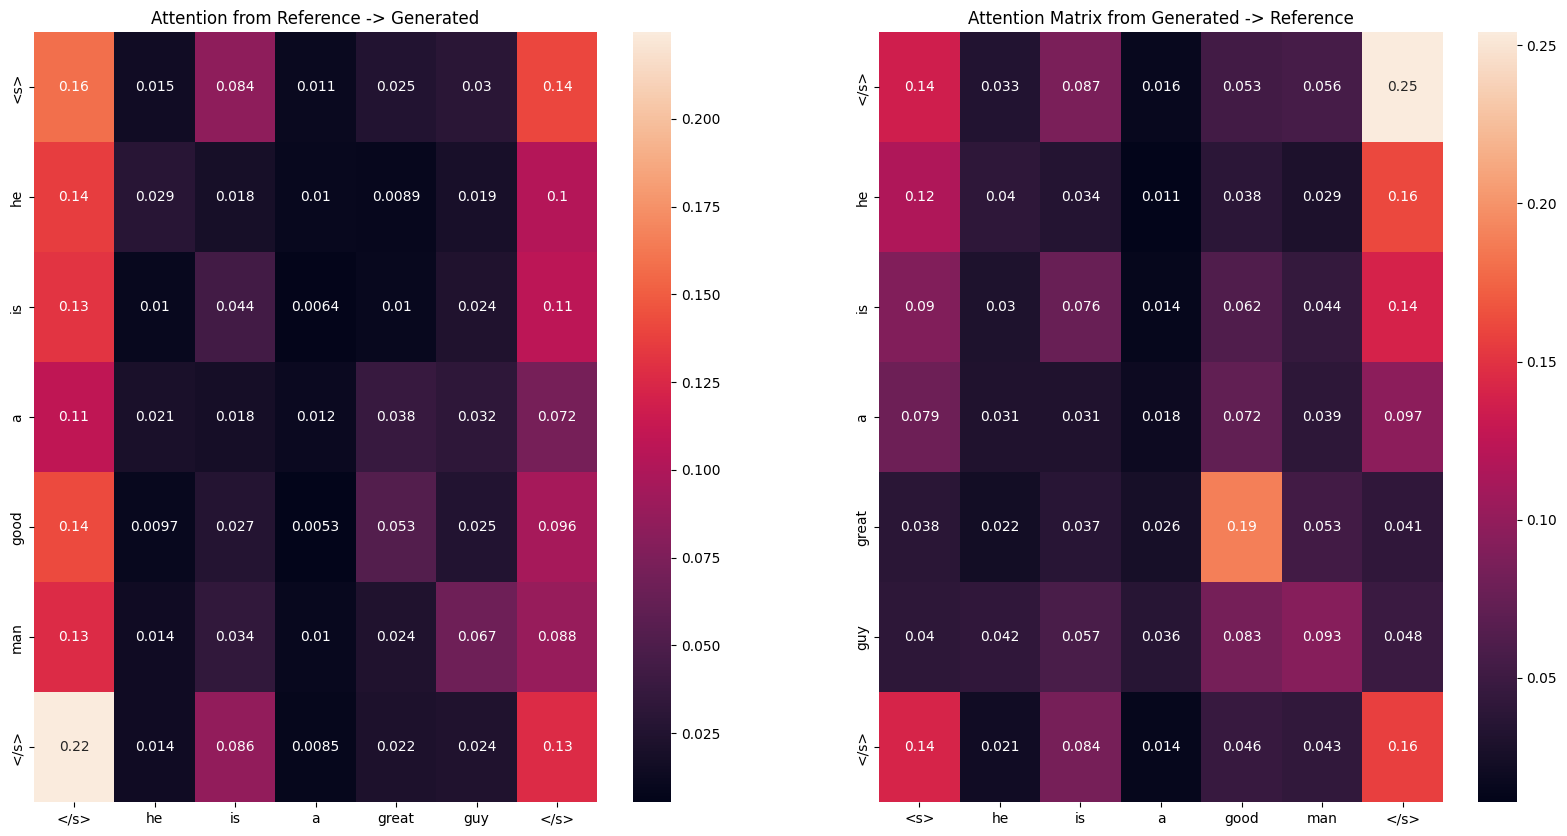

Similarity Score with Glove for sentence 1:  0.8181819319725037
Similarity Score with BERT for sentence 1:  0.8254177808761597
Rouge Score for sentence 1:  {'rouge1': 0.6, 'rouge2': 0.5, 'rougeL': 0.6, 'rougeLsum': 0.6}


In [15]:
reference = "he is a good man"
predict1 = "he is a great guy"
print("Similarity Score with Glove for sentence 1: ", similarity_score(reference , predict1 , plot_attention=True , embeddings='glove'))
print("Similarity Score with BERT for sentence 1: ", similarity_score(reference , predict1 , plot_attention=False , embeddings='bert'))
print("Rouge Score for sentence 1: ", rogue.compute(predictions=[predict1] , references=[reference]))
